We'll be creating a user-item collaborative filtering recommendation system using MovieLens data. We've downloaded a ratings dataset and a movies dataset from https://grouplens.org/datasets/movielens/. Out of the various datasets available, we're working with the one labeled "recommended for education and development" which, according to the source website, has approximately 100k ratings and 9k movies by 600 users.

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

Let's take a look at the ratings dataset:

In [4]:
ratings = pd.read_csv('[filepath]/file.csv')
ratings.head()
ratings.tail()
# the columns are 'userId', 'movieId', 'rating', 'timestamp'
# there are 100836 rows in this dataset (numbered 0-100835)

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


Now let's look at the movies dataset:

In [6]:
movies = pd.read_csv('[filepath]/file.csv')
movies.head()
movies.tail()
# the columns are 'movieId', 'title', 'genres'
# there were 9742 rows (numbered 0-9741)

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


Exploring the ratings dataset first, let's see how many ratings, unique movies, and unique users we have:

In [7]:
total_ratings = len(ratings)
unique_movies = ratings['movieId'].nunique()
unique_users = ratings['userId'].nunique()

print(f"Total number of ratings: {total_ratings}\n")
print(f"Amount of unique movieId's: {unique_movies}")
print(f"Amount of unique users: {unique_users}\n")
print(f"Average number of ratings per user: {round(total_ratings/unique_users, 2)}")
print(f"Average number of ratings per movie: {round(total_ratings/unique_movies, 2)}")

Total number of ratings: 100836

Amount of unique movieId's: 9724
Amount of unique users: 610

Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


We should also look at how many ratings each user made since it probably varies:

In [8]:
user_occurs = ratings[['userId', 'movieId']].groupby('userId').count().reset_index()
user_occurs.columns = ['userId', 'unique_ratings']
user_occurs.head()
user_occurs.tail()
# there are 610 rows (numbered 0-609)

,userId,unique_ratings
605,606,1115
606,607,187
607,608,831
608,609,37
609,610,1302


In [9]:
print(f"The mean (or average) number of ratings for a user: {user_occurs['unique_ratings'].mean():.2f}.")

The mean (or average) number of ratings for a user: 165.30.


We can visualize how the ratings are distributed across the board:

Text(0.5, 1.0, 'Movie Ratings Distribution')

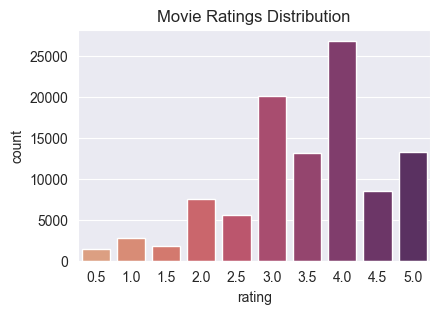

In [10]:
sns.set_style("darkgrid")
plt.figure(figsize = (10,3))
plt.subplot(1,2,1)
ax = sns.countplot(x = "rating", data = ratings, palette = "flare")
plt.title("Movie Ratings Distribution")

So 4.0 is the rating most commonly given. 

We can also take a look at which movies have the lowest and highest ratings:

In [11]:
avg_rating = ratings.groupby('movieId')[['rating']].mean()

lowest_rating = avg_rating['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rating]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [12]:
ratings[ratings['movieId'] == lowest_rating]

,userId,movieId,rating,timestamp
13633,89,3604,0.5,1520408880


However, taking a look above, it's important to note that only ONE user rated "Gypsy" this very low rating of 0.5.

In [13]:
highest_rating = avg_rating['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rating]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [14]:
ratings[ratings['movieId'] == highest_rating]

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


Similarly to the lowest-rated movie, it's important to understand that only TWO users rated "Lamerica" at 5.0. So, it shouldn't be taken for granted as the "best-rated" film in the MovieLens dataset.

Taking a cue from the last four blocks of code, a better way to evaluate movie popularity, according to the statistics world, is to look at the Bayesian Average (https://arpitbhayani.me/blogs/bayesian-average) because it gives you a score adjusted by weight instead of just sorting by ratings:

In [15]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()
# df.droplevel() - Return Series/DataFrame with requested index / column level(s) removed

In [16]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayes_avg(ratings):
    bayes_avg = (C * m + ratings.sum()) / (C + ratings.count())
    return bayes_avg

bayes_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayes_avg).reset_index()
bayes_avg_ratings.columns = ['movieId', 'bayes_avg']
movie_stats = movie_stats.merge(bayes_avg_ratings, on = 'movieId')

In [17]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayes_avg', ascending = False).head()

,movieId,count,mean,bayes_avg,title
277,318,317,4.429022,4.392070,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236457,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227052,Fight Club (1999)
224,260,251,4.231076,4.192646,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.190567,"Usual Suspects, The (1995)"


The above info shows that "The Shawshank Redemption," "The Godfather," and "Fight Club" are the top three best-rated films when determining ratings using the Bayesian Average.

Similarly, we can take a look at the worst-rated films:

In [18]:
movie_stats.sort_values('bayes_avg', ascending = True).head()

,movieId,count,mean,bayes_avg,title
1172,1556,19,1.605263,2.190377,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224426,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267268,Godzilla (1998)
1144,1499,27,1.925926,2.296800,Anaconda (1997)
1988,2643,16,1.687500,2.306841,Superman IV: The Quest for Peace (1987)


Now, in order to move on to carrying out collaborative filtering and create a movie recommender, we have to transform our data into a user-item matrix. Rows will represent users and columns represent items.

We'll use the create_X() function to create a sparse matrix X with four mapper dictionaries:

- user_map: maps user id to user index
- movie_map: maps movie id to movie index
- user_inv_map: maps user index to user id
- movie_inv_map: maps movie index to movie id

These dictionaries are necessary because they map which row and column of the utility matrix 
corresponds to which user ID and movie ID.

In [19]:
from scipy.sparse import csr_matrix

def create_X(df):
    N = df['userId'].nunique()
    M = df['movieId'].nunique()

    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
    
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]

    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
    
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

In [20]:
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

We should check the sparsity of our matrix by dividing the number of non-zero elements by the 
total number of elements:

In [21]:
sparsity = X.count_nonzero()/(X.shape[0] * X.shape[1])

print(f"Matrix sparsity: {round(sparsity * 100,2)}%")

Matrix sparsity: 1.7%


Apparently, the general rule of thumb is that the matrix sparsity should be not be lower than 0.5% (https://towardsdatascience.com/working-with-sparse-data-sets-in-pandas-and-sklearn-d26c1cfbe067) to generate reliable results. So since our sparsity percentage is 1.7%, which means that 1.7% of the cells are populated with ratings, we're okay.

We can save this user-item matrix to a file in order to work with it:

In [22]:
from scipy.sparse import save_npz

save_npz('[filepath]/file.npz', X)

In [23]:
b = np.load('user_item_matrix.npz')
b.files

['indices', 'indptr', 'format', 'shape', 'data']

In [24]:
b['data']

array([4. , 4. , 4.5, ..., 3.5, 3.5, 4. ])

Now we can build our K-Nearest Neighbors model.


In [25]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric = 'cosine', show_distance = False):
  
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k += 1
    kNN = NearestNeighbors(n_neighbors = k, algorithm = "auto", metric = metric)
    # Amir leaves algorithm on auto instead of "brute" force
    # for 'metric' we're not using the default 'minkowski' bc that uses Euclidean distance, which
    # we're not using (we're using 'cosine similarity' instead)
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html:
    # algorithm options are: {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
    kNN.fit(X)
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance = show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

Above, find_similar_movies() takes in a movieId and user-item matrix (X), and outputs a list of movies (k) that are similar to the movieId of interest.

Before putting it to use, we have to first create another mapper that maps movieId 
to title so that the results can be interpreted:

In [26]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 1

similar_ids = find_similar_movies(movie_id, X, k = 10)
movie_title = movie_titles[movie_id]

print(f'Because you watched "{movie_title}":')
for i in similar_ids:
    print(movie_titles[i])

Because you watched "Toy Story (1995)":
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)
Back to the Future (1985)


In [27]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

movie_id = 3
similar_ids = find_similar_movies(movie_id, X, k = 10, metric = "euclidean")

movie_title = movie_titles[movie_id]
print(f'Because you watched "{movie_title}":')
for i in similar_ids:
    print(movie_titles[i])

Because you watched "Grumpier Old Men (1995)":
Son in Law (1993)
Striptease (1996)
Juror, The (1996)
Flipper (1996)
Beverly Hillbillies, The (1993)
Bio-Dome (1996)
Kazaam (1996)
Angus (1995)
Tales from the Crypt Presents: Bordello of Blood (1996)
Substitute, The (1996)


Now, instead of a user-item collaborative filtering recommendation system, we're going to build a content-based recommendation system.

This is also a good method in case you run into the cold-start problem, which is a notorious problem that collaborative filtering suffers from. The issue is that new users or items with no ratings/interactions get excluded by the recommender system. One way to deal with this is by using this content-based filtering in which recommendations are generated based on user and item features. We'll be creating item-item recommendations.

So if under this scenario, we assume that we know very little about our current users because we don't have enough interaction data in our system to rely on collaborative filtering, one thing we can rely on is movie features: which genres a movie belongs to and which year it was released.

In [28]:
movies = pd.read_csv("[filepath]/file.csv")
movies.head()
movies.tail()
# the columns are 'movieId', 'title', 'genres'
# there were 9742 rows (numbered 0-9741)

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


But before exploring our movies dataset, first we'll get rid of the pipe "|" that appears between each listed genre and turn it into a list of genres:

In [29]:
movies['genres'] = movies['genres'].apply(lambda x:x.split("|"))
movies.head()
movies.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]"
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]"
9739,193585,Flint (2017),[Drama]
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]"
9741,193609,Andrew Dice Clay: Dice Rules (1991),[Comedy]


Then, we can count how frequently each genre appears in our dataset:

In [30]:
from collections import Counter

genres_count = Counter(genre for genres in movies['genres'] for genre in genres)
print(f"There are {len(genres_count)} different labels of genre.")
genres_count

There are 20 different labels of genre.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

We should remove the "no genres listed" label since that won't help us.

In [31]:
movies = movies[movies['genres']!='(no genres listed)']

del genres_count['(no genres listed)']

In [32]:
print(f'There are now {len(genres_count)} different labels of genre after deleting "no genres listed":')
genres_count

There are now 19 different labels of genre after deleting "no genres listed":


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87})

In [33]:
print("The most common genres in descending order: \n", genres_count.most_common(19))

The most common genres in descending order: 
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596), ('Adventure', 1263), ('Crime', 1199), ('Sci-Fi', 980), ('Horror', 978), ('Fantasy', 779), ('Children', 664), ('Animation', 611), ('Mystery', 573), ('Documentary', 440), ('War', 382), ('Musical', 334), ('Western', 167), ('IMAX', 158), ('Film-Noir', 87)]


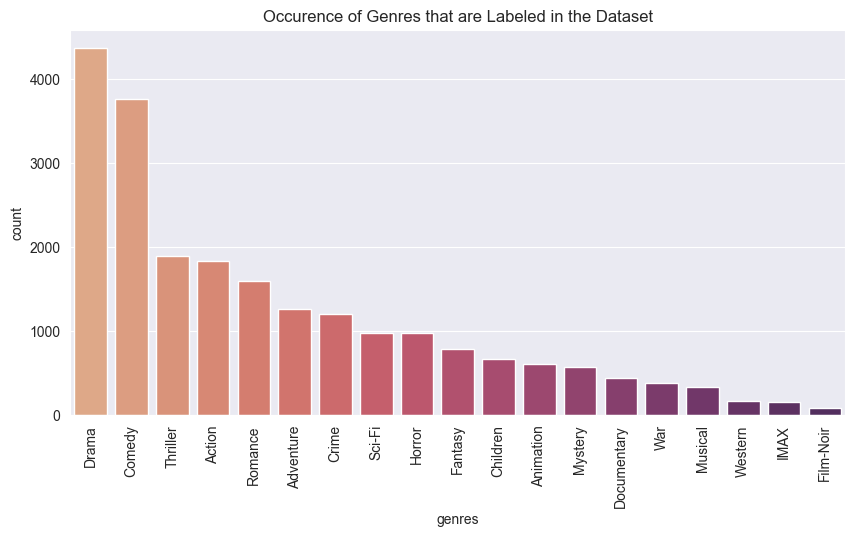

In [34]:
genres_count_df = pd.DataFrame([genres_count]).T.reset_index()
genres_count_df.columns = ["genres", "count"]
genres_count_df = genres_count_df.sort_values(by = 'count', ascending = False)

sns.set_style("darkgrid")
plt.figure(figsize = (10,5))
sns.barplot(x = "genres", y = "count", data = genres_count_df, palette = "flare")
# color palette options: https://seaborn.pydata.org/tutorial/color_palettes.html
plt.xticks(rotation = 90)
plt.title("Occurence of Genres that are Labeled in the Dataset")
plt.show()

Next, we'll separate out the years currently included in the titles and add them to a new column:

In [35]:
import re 

def extract_year_from_title(title):
    t = title.split(' ') # splits out each word
    year = None
    if re.search(r'\(\d+\)', t[-1]): # regex searches for the year as '\d+' searches for [0-9] 
        # or more times
        year = t[-1].strip('()') # strips the brackets 
        year = int(year) # converts year into integer
    return year

Testing to see if the above works:

In [37]:
title = "Waiting to Exhale (1995)"
year = extract_year_from_title(title)
print(f"Year of release: {year}")
print(type(year))

Year of release: 1995
<class 'int'>


We can apply the above function to all the titles:

In [39]:
movies['year'] = movies['title'].apply(extract_year_from_title)
movies.head()
movies.tail()

,movieId,title,genres,year
9737,193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017.0
9738,193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017.0
9739,193585,Flint (2017),[Drama],2017.0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),"[Action, Animation]",2018.0
9741,193609,Andrew Dice Clay: Dice Rules (1991),[Comedy],1991.0


In [40]:
movies['year'].nunique()

106

100+ unique years is a lot so we can round the years into decades to simplify things. But first, we can remove movies that don't have a year listed for when it was released:

In [41]:
print(f"Original number of movies: {movies['movieId'].nunique()}")

Original number of movies: 9742


In [42]:
movies = movies[~movies['year'].isnull()]
print(f"Number of movies after removing ones with missing years: {movies['movieId'].nunique()}")

Number of movies after removing ones with missing years: 9718


So now we have 24 less movies that didn't have a year in the title.

Next, to simplify our data, we'll round the number down to the nearest decade:

In [43]:
x = 1985

def get_decade(year):
    year = str(year)
    decade_prefix = year[0:3] # get first 3 digits of year
    decade = f'{decade_prefix}0' # append 0 at the end
    return int(decade)

get_decade(x)

1980

In [44]:
def round_down(year):
    return year - (year%10)

round_down(x)

1980

We can round all the years down and then create a new column called 'decade':

In [45]:
movies['decade'] = movies['year'].apply(round_down)

Now, in order to build our content-based filtering recommenation system, we have to reconfigure our dataset so that rows represent movies and columns represent features (i.e., genres and decades).

First, in the "genres" column, we'll have the data represented in a binary way, so that "1" means that the movie falls under a given genre while "0" means that it doesn't.

In [47]:
genres = list(genres_count.keys())

for genre in genres:
    movies[genre] = movies['genres'].transform(lambda x: int(genre in x))

We can check the transformation:

movies[genres].head()
movies[genres].tail()

Next, we should reconfigure the "decade" column so that each decade is in its own column.

In [50]:
movie_decades = pd.get_dummies(movies['decade']) 
# get_dummies() turns categorical variables into binary ones
movie_decades.head()
#movie_decades.tail()

,1900.0,1910.0,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


Next, we can combine the genres and decades features that we just manipulated through concatenation:

In [51]:
movie_features = pd.concat([movies[genres], movie_decades], axis = 1)
# concat() concatenates (appends) genres and decades into a single dataframe
movie_features.head()
#movie_features.tail()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,...,1920.0,1930.0,1940.0,1950.0,1960.0,1970.0,1980.0,1990.0,2000.0,2010.0
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


So now that we have all of our features in one dataframe, we can finally start building the recommender.

In [52]:
from sklearn.metrics.pairwise import cosine_similarity
# we're using cosine similarity to measure distance rather than the other
# options: https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/
# because "it is very efficient to evaluate, especially for sparse vectors"

cosine_sim = cosine_similarity(movie_features, movie_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (9718, 9718)


Our cosine similarity matrix is populated with values between 0 and 1 which represent the degree of similarity between movies along the x and y axes.

Next, we'll create our movie finder function.

We'll use the python library fuzzywuzzy in case the title that a user enters is misspelled. Therefore, it'll match whatever's closest instead of just not being able to return any info at all. 

In [53]:
from fuzzywuzzy import fuzz, process

def movie_finder(title):
    all_titles = movies['title'].tolist()
    closest_match = process.extractOne(title, all_titles)
    return closest_match[0]

/Users/sarakim/opt/anaconda3/envs/ML-pratt/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


We can test it out:

In [54]:
title = movie_finder('Foldeneye')
title

'GoldenEye (1995)'

Next, to get relevant recommendations for "GoldenEye," we need to find its index in the cosine similarity matrix. So we have to create a movie index mapper which maps a movie title to the index that it represents in our matrix.

In [55]:
movie_idx = dict(zip(movies['title'], list(movies.index)))
# in this index, the keys are movie titles, and the values are the movie indices
idx = movie_idx[title]
idx

9

So, we can see that "GoldenEye" is represented by index 9 in our matrix. To see the 10 most similar movies to "GoldenEye":

In [56]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_movies = [i[0] for i in sim_scores]
# similar_movies is an array representing GoldenEye's top 10 recommendations

We can get the movie titles that correpsond to the 10 recommended movie array positions by either creating an inverse movie_idx mapper or using iloc on the title column of the movies dataframe:

In [57]:
print(f'Users who watched "{title}" also enjoyed:')
movies['title'].iloc[similar_movies]

Users who watched "GoldenEye (1995)" also enjoyed:


84            Broken Arrow (1996)
378            Cliffhanger (1993)
431     Executive Decision (1996)
479     Surviving the Game (1994)
592              Rock, The (1996)
648         Chain Reaction (1996)
754           Maximum Risk (1996)
1053            Die Hard 2 (1990)
1145              Anaconda (1997)
1171               Con Air (1997)
Name: title, dtype: object

Let's test the recommender further with other movie titles:

In [58]:
def get_content_based_recommendations(title_string, n_recommendations = 10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:(n_recommendations + 1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f'Users who watched "{title}" also enjoyed:')
    print(movies['title'].iloc[similar_movies])

In [59]:
get_content_based_recommendations("don't tell mom the babysitter's dead", 10)

Users who watched "Don't Tell Mom the Babysitter's Dead (1991)" also enjoyed:
17                         Four Rooms (1995)
18     Ace Ventura: When Nature Calls (1995)
58                           Bio-Dome (1996)
61                             Friday (1995)
79                        Black Sheep (1996)
90                          Mr. Wrong (1996)
92                      Happy Gilmore (1996)
104           Steal Big, Steal Little (1995)
108            Flirting With Disaster (1996)
113                    Down Periscope (1996)
Name: title, dtype: object


In [62]:
get_content_based_recommendations("The Adventures of Baron Munchausen", 10)

Users who watched "Adventures of Baron Munchausen, The (1988)" also enjoyed:
3376                Erik the Viking (1989)
2233                   Time Bandits (1981)
2798    Big Trouble in Little China (1986)
1515      Devil and Max Devlin, The (1981)
1591      Adventures in Babysitting (1987)
1598              Dark Crystal, The (1982)
1608        Gods Must Be Crazy, The (1980)
1628                    Beetlejuice (1988)
1858               Crocodile Dundee (1986)
2157                      Excalibur (1981)
Name: title, dtype: object
